# 文件分類
主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「中文」的文件分類，使用dcard的三個版別文章做示範。

## 分析目標
+ 資料內容：
    + 資料來源：Dcard
    + 版別：股市、穿搭、youtuber

* 分析主題：將三個版別的文章合起來，訓練模型能預測版別，再用分類模型進行文件的版別分類。

* 步驟：
    1. 載入套件
    2. 基本的分類模型流程，包含以下三步驟：
        * 前處理 (preprocess)
        * 建模 (train model)
        * 評估與預測 (evaluation and predict)
    3. cross validation
    4. 不同分類器的效果
    5. 可解釋的可視化模型結果
    6. 預測其他來源的資料並進行比對

## 1. 載入套件

In [136]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

設定中文字體

In [137]:
import matplotlib
print(matplotlib.get_configdir())


/Users/tony/.matplotlib


Text(0.5, 1.0, '聲量圖')

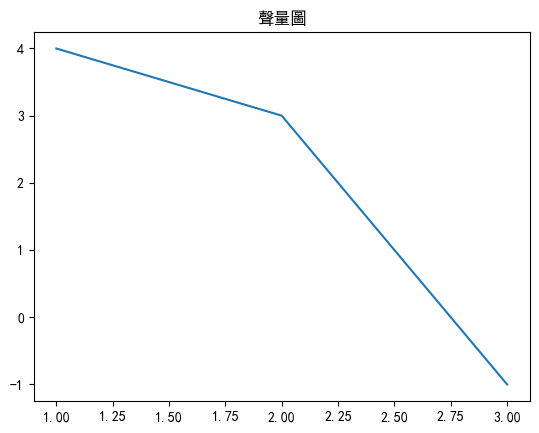

In [138]:
# https://zhuanlan.zhihu.com/p/566430362
# from matplotlib import font_manager
# font_set = {f.name for f in font_manager.fontManager.ttflist}
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.plot((1, 2, 3), (4, 3, -1))
plt.title("聲量圖")

## 2. 文字前處理
`sna2024s_7_a16a93362a_15.csv`,`sna2024s_7_a16a93362a_15-2.csv`,`sna2024s_7_a16a93362a_15-3.csv`裡面包含了要進行訓練的資料。
- 版別：股市、youtuber、穿搭
- 時間範圍：2024/01/01 ~ 2024/04/08
- 工作流程平台搜尋/排除關鍵字：無

#### 三筆資料都個別採取其中400筆並進行合併

In [139]:
data1 = pd.read_csv('raw_data/sna2024s_7_a16a93362a_15.csv').head(400)
data2 = pd.read_csv('raw_data/sna2024s_7_a16a93362a_15-2.csv').head(400)
data3 = pd.read_csv('raw_data/sna2024s_7_a16a93362a_15-3.csv').head(400)
# 步驟 3: 合併資料
combined_data = pd.concat([data1, data2, data3])

# 步驟 4: 儲存到新的 CSV 檔案
combined_data.to_csv('combined_data.csv', index=False)

In [140]:
udn = pd.read_csv("combined_data.csv")  # 匯資料
udn.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/youtuber/p/255125589,2024-03-30 13:21:10,藍狐獴-全職戀人EP8,https://youtu.be/8YrYFDx6YLc?si=4RyVAs-8_hahbe...,youtuber,12,生物科技學系,M,亞洲大學
1,2,Dcard,https://www.dcard.tw/f/youtuber/p/255107233,2024-03-28 13:46:43,這種戲劇都沒落了嗎？,剛剛滑到這支影片\n其實章魚燒梗蠻好笑的欸\n還有人在看各種同學嗎\n發現他們後來的影片加了...,youtuber,3,NaN,M,輔仁大學
2,3,Dcard,https://www.dcard.tw/f/youtuber/p/255124706,2024-03-30 11:39:33,陪沈團的駱楊分手了嗎？,前陣子在楊的私帳看到這篇文⬇️⬇️\n\n\n八婆直覺是感情問題🤔🤔\n加上剛才突然搜不到楊...,youtuber,22,NaN,M,輔仁大學


In [141]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
# print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['boardID'].value_counts()}")

number of posts: 1200
category: 
boardID
youtuber    400
dressup     400
stock       400
Name: count, dtype: int64


+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字）

### 2.1 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [142]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/youtuber/p/255125589,2024-03-30 13:21:10,藍狐獴全職戀人,這集大家促膝長談談的很深入談到各自的家庭和成長不過和有自己的顧慮沒有想聊還談到了約砲找來的來...,youtuber,12,生物科技學系,M,亞洲大學
1,2,Dcard,https://www.dcard.tw/f/youtuber/p/255107233,2024-03-28 13:46:43,這種戲劇都沒落了嗎,剛剛滑到這支影片其實章魚燒梗蠻好笑的欸還有人在看各種同學嗎發現他們後來的影片加了一些新人但現...,youtuber,3,NaN,M,輔仁大學
2,3,Dcard,https://www.dcard.tw/f/youtuber/p/255124706,2024-03-30 11:39:33,陪沈團的駱楊分手了嗎,前陣子在楊的私帳看到這篇文八婆直覺是感情問題加上剛才突然搜不到楊的私帳好像關版了再去駱的版找...,youtuber,22,NaN,M,輔仁大學


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [143]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "boardID"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,boardID
0,藍狐獴全職戀人這集大家促膝長談談的很深入談到各自的家庭和成長不過和有自己的顧慮沒有想聊還談到...,https://www.dcard.tw/f/youtuber/p/255125589,youtuber
1,這種戲劇都沒落了嗎剛剛滑到這支影片其實章魚燒梗蠻好笑的欸還有人在看各種同學嗎發現他們後來的影...,https://www.dcard.tw/f/youtuber/p/255107233,youtuber
2,陪沈團的駱楊分手了嗎前陣子在楊的私帳看到這篇文八婆直覺是感情問題加上剛才突然搜不到楊的私帳好...,https://www.dcard.tw/f/youtuber/p/255124706,youtuber
3,想分享一下自己的遊戲頻道想分享一下自己的頻道剛剛起步主要是粵語配繁體中文字幕大家有興趣可以試...,https://www.dcard.tw/f/youtuber/p/255115766,youtuber
4,心碎虐童細節曝光竟稱親兒是惡魔近日美國一起虐童案件震驚各界在頻道現已被刪除以分享家庭育兒經驗...,https://www.dcard.tw/f/youtuber/p/255105636,youtuber


In [144]:
# 看看有幾篇文章
print(f"total docs: {udn.shape[0]}")


total docs: 1166


### 2.2 斷詞

In [145]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 載入自定義辭典：一個詞一行，每行分詞語、詞頻(可省)、詞性(可省)
jieba.load_userdict("dict/user_dict.txt")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from /Users/tony/Desktop/MIS581/SMA_2nd/week7/dict/dict.txt.big ...
Loading model from cache /var/folders/dd/3xjn4tx56812dj8npgdggkh40000gn/T/jieba.u72a33dfcb9d11d9cc7f82fd9c6265fcd.cache
Loading model cost 0.501 seconds.
Prefix dict has been built successfully.


In [146]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [147]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

,content,artUrl,boardID,words
0,藍狐獴全職戀人這集大家促膝長談談的很深入談到各自的家庭和成長不過和有自己的顧慮沒有想聊還談到...,https://www.dcard.tw/f/youtuber/p/255125589,youtuber,藍狐 全職 戀人 這集 促膝長談 深入 談到 家庭 成長 顧慮 聊還 談到 找來 來賓 幾個...
1,這種戲劇都沒落了嗎剛剛滑到這支影片其實章魚燒梗蠻好笑的欸還有人在看各種同學嗎發現他們後來的影...,https://www.dcard.tw/f/youtuber/p/255107233,youtuber,戲劇 沒落 剛剛 滑到 這支 影片 章魚燒 梗蠻 好笑 同學 發現 影片 一些 新人 現在 好像
2,陪沈團的駱楊分手了嗎前陣子在楊的私帳看到這篇文八婆直覺是感情問題加上剛才突然搜不到楊的私帳好...,https://www.dcard.tw/f/youtuber/p/255124706,youtuber,沈團 駱楊 分手 陣子 私帳 看到 這篇 文八婆 直覺 感情 問題 突然 不到 私帳 好像 ...
3,想分享一下自己的遊戲頻道想分享一下自己的頻道剛剛起步主要是粵語配繁體中文字幕大家有興趣可以試...,https://www.dcard.tw/f/youtuber/p/255115766,youtuber,分享 一下 遊戲 頻道 分享 一下 頻道 剛剛 起步 主要 粵語 繁體中文 字幕 興趣 試試...
4,心碎虐童細節曝光竟稱親兒是惡魔近日美國一起虐童案件震驚各界在頻道現已被刪除以分享家庭育兒經驗...,https://www.dcard.tw/f/youtuber/p/255105636,youtuber,心碎 虐童 細節 曝光 竟稱 親兒 惡魔 近日 美國 一起 虐童 案件 震驚 各界 頻道 現...


### 2.3 資料集基本檢視

檢視資料內容

In [148]:
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['boardID'].value_counts()}")


total posts: 1166
category: 
boardID
youtuber    399
dressup     389
stock       378
Name: count, dtype: int64


## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

In [149]:
data = udn
X = data["words"]
y = data["boardID"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

1022    請益 疑問 永豐 大戶 報酬 試算 請問 有人 知道 永豐 大戶 報酬 算是 一下 輝達 績...
374     電類 科系 大學 研究所 差異 陽明 交通 大學 電子 研究所 實驗室 日常 好久沒 剪片 ...
256     藍狐 請問 有人 記得 之前 藍狐 蒙有 交友 軟體 合作 會員 免費 一個月 影片 不到 ...
397                               電腦 改版 今天 打開 發現 有人 有變 習慣
1016    波浪理論 當的 套利 下車 價值 投資 年月日 春分 過後 第一個 交易日 加權指數 首次 ...
Name: words, dtype: object
1022       stock
374     youtuber
256     youtuber
397     youtuber
1016       stock
Name: boardID, dtype: object


In [150]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['boardID'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
boardID
youtuber    34.219554
dressup     33.361921
stock       32.418525
Name: proportion, dtype: float64

train percentage :
boardID
youtuber    35.784314
stock       32.720588
dressup     31.495098
Name: proportion, dtype: float64

test percentage :
boardID
dressup     37.714286
stock       31.714286
youtuber    30.571429
Name: proportion, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字

### 3.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [151]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [152]:
X_train.head()

1022    請益 疑問 永豐 大戶 報酬 試算 請問 有人 知道 永豐 大戶 報酬 算是 一下 輝達 績...
374     電類 科系 大學 研究所 差異 陽明 交通 大學 電子 研究所 實驗室 日常 好久沒 剪片 ...
256     藍狐 請問 有人 記得 之前 藍狐 蒙有 交友 軟體 合作 會員 免費 一個月 影片 不到 ...
397                               電腦 改版 今天 打開 發現 有人 有變 習慣
1016    波浪理論 當的 套利 下車 價值 投資 年月日 春分 過後 第一個 交易日 加權指數 首次 ...
Name: words, dtype: object

In [153]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<816x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 20567 stored elements in Compressed Sparse Row format>

In [154]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [155]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names_out()[:10])


['一下' '一些' '一件' '一位' '一個月' '一半' '一堆' '一天' '一套' '一定']


In [156]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['股票']

{'請益': 816, '永豐': 555, '報酬': 249, '請問': 814, '有人': 501, '知道': 652, '算是': 687, '一下': 0, '輝達': 864, '績效': 720, '覺得': 786, '數字': 461, '假設': 113, '一個月': 4, '連續': 890, '大學': 261, '差異': 324, '電子': 960, '日常': 475, '最近': 498, '今天': 82, '藍狐': 763, '記得': 797, '之前': 67, '合作': 204, '會員': 500, '影片': 356, '不到': 50, '發現': 623, '習慣': 728, '價值': 121, '投資': 408, '加權指數': 167, '維持': 711, '降息': 949, '買盤': 828, '進場': 894, '收盤價': 447, '累積': 699, '期間': 515, '有趣': 507, '當初': 617, '造成': 888, '科技': 667, '台灣': 201, '台積': 202, '時間': 485, '歷史': 542, '漲幅': 577, '目的': 636, '半導體': 176, '上漲': 33, '預期': 972, '營收': 585, '至少': 752, '成長': 395, '一年': 10, '目前': 633, '低點': 98, '回測': 233, '高點': 993, '就要': 314, '容易': 301, '主要': 65, '壓力': 253, '避免': 909, '進入': 893, '報告': 248, '自然': 750, '台幣': 200, '過去': 898, '經驗': 709, '得到': 362, '股市': 738, '通常': 885, '外資': 256, '賣壓': 843, '集中': 959, '市場': 328, '金額': 931, '億元': 123, '之後': 69, '出現': 145, '下跌': 46, '認為': 808, '股息': 739, '喜歡': 224, '投資人': 409, '規模': 784, '心態': 367, '代表': 87, '新手': 

742

In [157]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(816, 1000)
(350, 1000)


In [158]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [159]:
clf.classes_

array(['dressup', 'stock', 'youtuber'], dtype=object)

In [160]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['stock' 'stock' 'dressup' 'dressup' 'youtuber' 'youtuber' 'youtuber'
 'dressup' 'youtuber' 'stock']


In [161]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(350, 3)


array([0.11699894, 0.82359783, 0.05940323])

In [162]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     dressup       0.92      0.92      0.92       132
       stock       0.94      0.92      0.93       111
    youtuber       0.90      0.93      0.91       107

    accuracy                           0.92       350
   macro avg       0.92      0.92      0.92       350
weighted avg       0.92      0.92      0.92       350



In [163]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[121,   4,   7],
       [  5, 102,   4],
       [  6,   2,  99]])

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'dressup'), Text(0, 1.5, 'stock'), Text(0, 2.5, 'youtuber')])

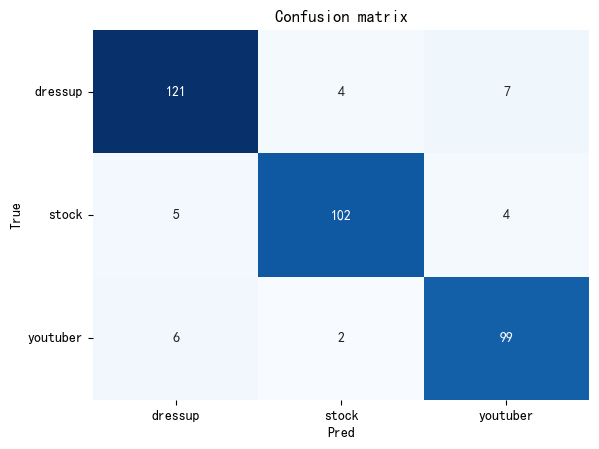

In [164]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

### 3.4 tfidf

改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [165]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.12789638, 0.        , 0.        , 0.        , 0.20545026,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [166]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

     dressup       0.93      0.96      0.95       132
       stock       0.97      0.95      0.96       111
    youtuber       0.94      0.93      0.93       107

    accuracy                           0.95       350
   macro avg       0.95      0.95      0.95       350
weighted avg       0.95      0.95      0.95       350



### 3.5 CV

接著介紹 cross-validation。CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。

* figure1: 

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png"  width="1000">

* figure 2:  

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

source: <https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection>

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [167]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.00908899, 0.00997996, 0.0075438 , 0.00792766, 0.00826311]),
 'score_time': array([0.0027411 , 0.00262809, 0.00269413, 0.00268531, 0.00350094]),
 'test_f1_macro': array([0.93377215, 0.9496092 , 0.9254072 , 0.91349665, 0.96386297]),
 'test_precision_macro': array([0.93560484, 0.95183647, 0.92626263, 0.91904532, 0.96875   ]),
 'test_recall_macro': array([0.93261453, 0.94886435, 0.92536019, 0.9116487 , 0.96178036])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [168]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

     dressup       0.95      0.88      0.91       257
       stock       0.97      0.97      0.97       267
    youtuber       0.90      0.96      0.93       292

    accuracy                           0.94       816
   macro avg       0.94      0.94      0.94       816
weighted avg       0.94      0.94      0.94       816



## 4. 比較不同模型效果

In [169]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)

    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report


from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
def train_cv_xgb(vectorizer, clf, X, y):
    # 初始化標籤編碼器
    label_encoder = LabelEncoder()
    # 將原始字符串標籤轉換為整數
    y_encoded = label_encoder.fit_transform(y)
    
    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y_encoded, cv=5, return_estimator=True)
    
    y_pred_encoded = cross_val_predict(clf, vec_X, y_encoded, cv=5)
    # 將預測結果從整數轉換回字符串標籤
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = label_encoder.classes_  # 使用原始字符串標籤
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred, labels=classes)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="xgb.XGBClassifier()" + " Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y_encoded)  # 注意這裡使用轉換後的標籤來訓練最終模型
    # return the model object
    return cls_report

              precision    recall  f1-score   support

     dressup       0.95      0.88      0.91       257
       stock       0.97      0.97      0.97       267
    youtuber       0.90      0.96      0.93       292

    accuracy                           0.94       816
   macro avg       0.94      0.94      0.94       816
weighted avg       0.94      0.94      0.94       816



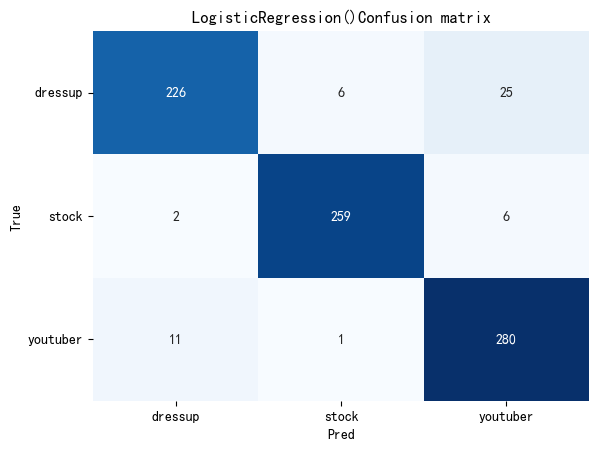

In [170]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic


              precision    recall  f1-score   support

     dressup       0.95      0.88      0.91       257
       stock       0.97      0.97      0.97       267
    youtuber       0.90      0.96      0.93       292

    accuracy                           0.94       816
   macro avg       0.94      0.94      0.94       816
weighted avg       0.94      0.94      0.94       816

now training: clf_dtree
              precision    recall  f1-score   support

     dressup       0.80      0.82      0.81       257
       stock       0.86      0.90      0.88       267
    youtuber       0.86      0.80      0.83       292

    accuracy                           0.84       816
   macro avg       0.84      0.84      0.84       816
weighted avg       0.84      0.84      0.84       816

now training: clf_svm
              precision    recall  f1-score   support

     dressup       0.95      0.87      0.91       257
       stock       0.98      0.96      0.97       267
    youtuber       0.88      

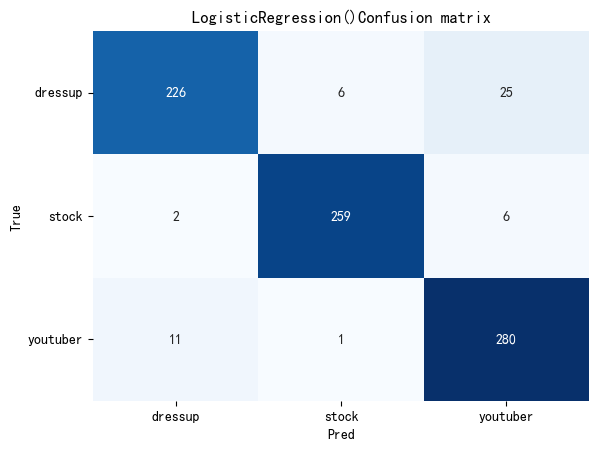

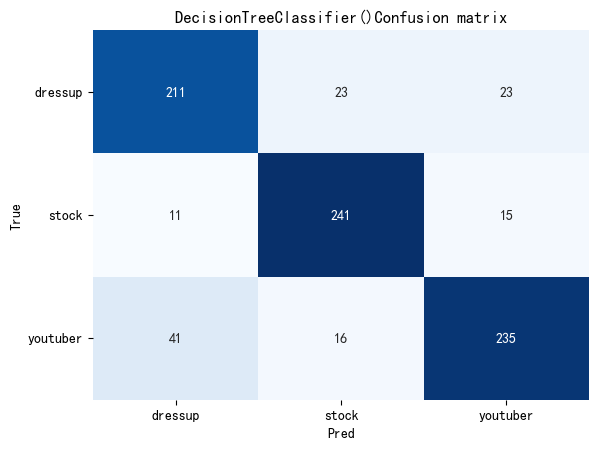

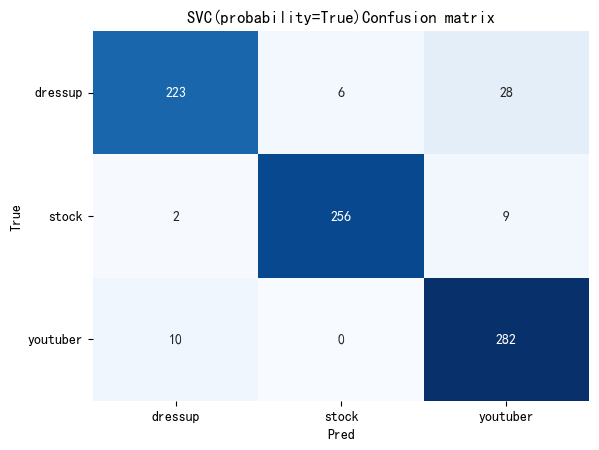

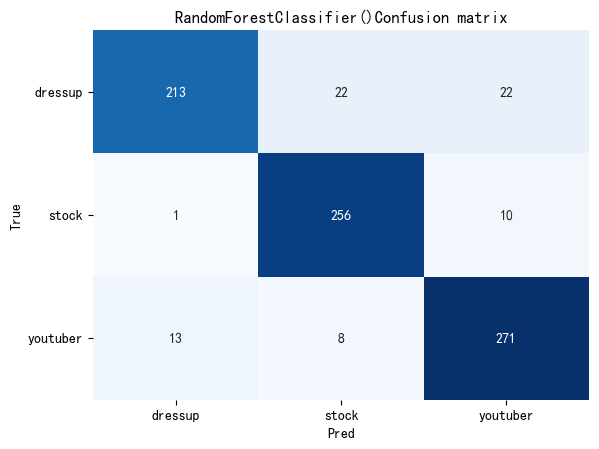

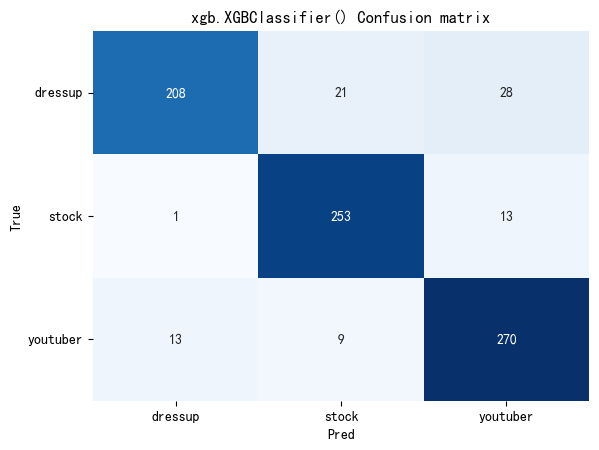

In [171]:
# 準備訓練資料
X = data["words"]
y = data["boardID"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
model_set['clf_xgb'] = xgb.XGBClassifier(objective='multi:softmax', num_class=3, n_estimators=500, seed=3)


# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    if k == 'clf_xgb':
        print("="*100)
        print(f"now training: {k}")
        result_set[k] = train_cv_xgb(vectorizer, model, X_train, y_train)
        print("="*100)        
        continue
    else:
        print("="*100)
        print(f"now training: {k}")
        result_set[k] = train_cv(vectorizer, model, X_train, y_train)
        print("="*100)


In [172]:
result_set['clf_logistic']

{'dressup': {'precision': 0.9456066945606695,
  'recall': 0.8793774319066148,
  'f1-score': 0.9112903225806451,
  'support': 257.0},
 'stock': {'precision': 0.9736842105263158,
  'recall': 0.9700374531835206,
  'f1-score': 0.9718574108818011,
  'support': 267.0},
 'youtuber': {'precision': 0.9003215434083601,
  'recall': 0.958904109589041,
  'f1-score': 0.9286898839137645,
  'support': 292.0},
 'accuracy': 0.9375,
 'macro avg': {'precision': 0.9398708161651151,
  'recall': 0.9361063315597254,
  'f1-score': 0.9372792057920702,
  'support': 816.0},
 'weighted avg': {'precision': 0.9385888423870827,
  'recall': 0.9375,
  'f1-score': 0.9373345437640759,
  'support': 816.0}}

In [173]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_logistic
{'accuracy': 0.9375,
 'dressup': {'f1-score': 0.9112903225806451,
             'precision': 0.9456066945606695,
             'recall': 0.8793774319066148,
             'support': 257.0},
 'macro avg': {'f1-score': 0.9372792057920702,
               'precision': 0.9398708161651151,
               'recall': 0.9361063315597254,
               'support': 816.0},
 'stock': {'f1-score': 0.9718574108818011,
           'precision': 0.9736842105263158,
           'recall': 0.9700374531835206,
           'support': 267.0},
 'weighted avg': {'f1-score': 0.9373345437640759,
                  'precision': 0.9385888423870827,
                  'recall': 0.9375,
                  'support': 816.0},
 'youtuber': {'f1-score': 0.9286898839137645,
              'precision': 0.9003215434083601,
              'recall': 0.958904109589041,
              'support': 292.0}}


In [174]:
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     dressup       0.93      0.96      0.95       132
       stock       0.97      0.95      0.96       111
    youtuber       0.94      0.93      0.93       107

    accuracy                           0.95       350
   macro avg       0.95      0.95      0.95       350
weighted avg       0.95      0.95      0.95       350



In [175]:
model_set['clf_logistic'].predict(vectorizer.transform(["市場"]).toarray())

array(['stock'], dtype=object)

* 最佳的 model 為 clf_logistic，而 Decision Tree 跟 XGBoost 的表現較差

## 5. 分析可解釋模型的結果

### 5.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉logistic regression + cv tokenizer 為例

In [176]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

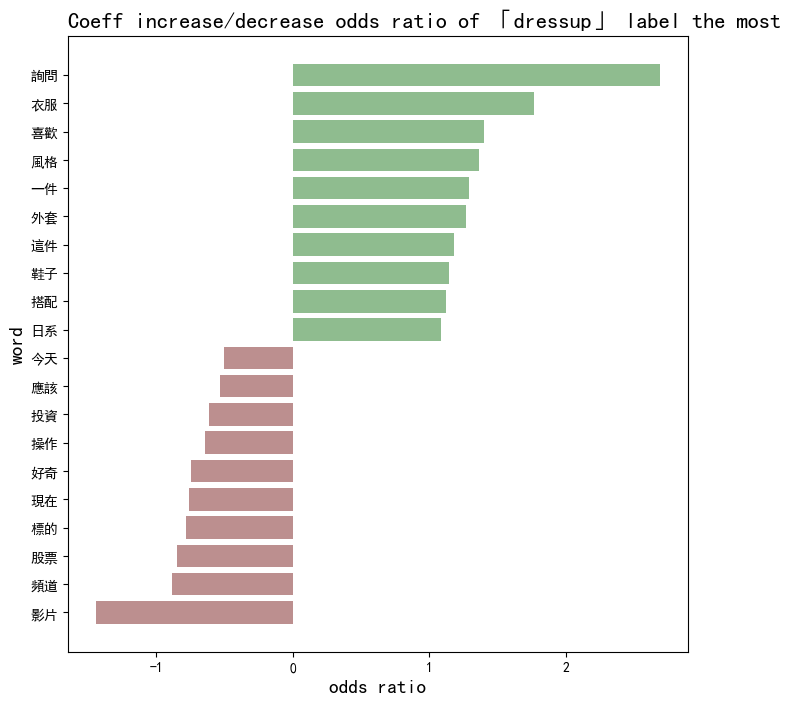

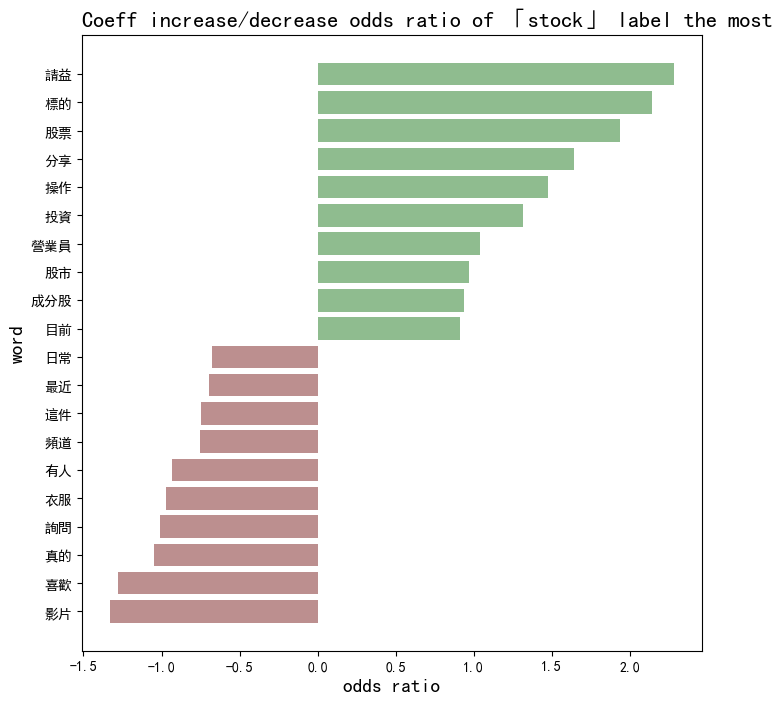

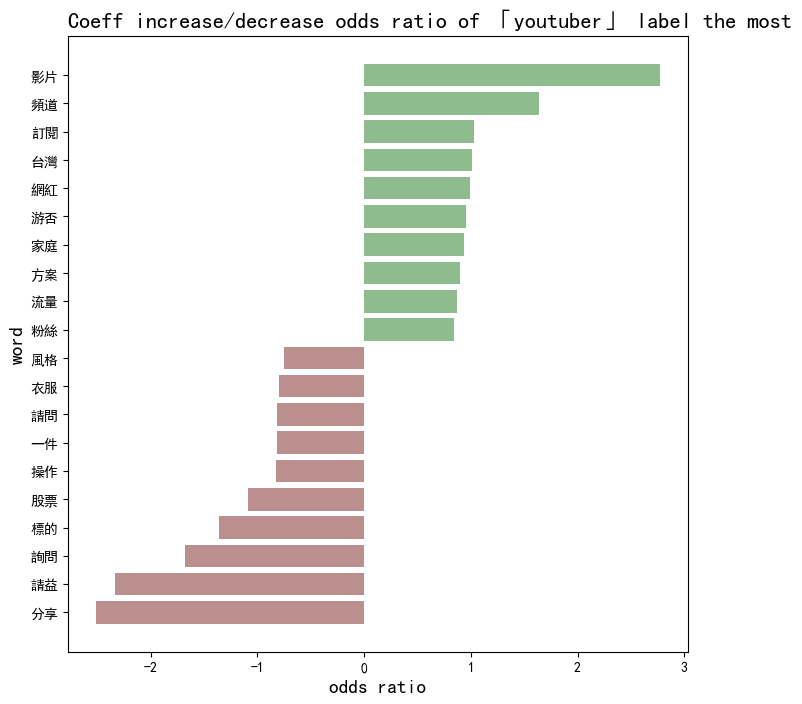

In [177]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

* 穿搭版中可以看出來許多人都會有在穿搭版詢問該如何搭配、風格之類的
* 股市版則是請益哪些標的等等
* 網紅流量等字眼對於分類YT版的影響也較大

## 6. 預測新聞類別

`sna2024s_7_a16a93362a_17.csv` 
- 來源：ptt
- 版別：stock
- 時間範圍：2024/01/01 ~ 2024/04/08
- 工作流程平台搜尋/排除關鍵字：無

`sna2024s_7_a16a93362a_20.csv` 
- 來源：mobile01
- 版別：時尚
- 時間範圍：2024/01/01 ~ 2024/04/08
- 工作流程平台搜尋/排除關鍵字：無

`sna2024s_7_a16a93362a_17.csv` 
- 來源：dcard
- 版別：youtuber
- 時間範圍：2023/01/01 ~ 2023/03/01
- 工作流程平台搜尋/排除關鍵字：無

In [178]:
data1 = pd.read_csv('raw_data/sna2024s_7_a16a93362a_17.csv').head(400)
data2 = pd.read_csv('raw_data/sna2024s_7_a16a93362a_20.csv').head(400)
data3 = pd.read_csv('raw_data/sna2024s_7_a16a93362a_23.csv').head(400)


In [179]:
data1 = data1.rename(columns={'artCatagory': 'boardID'})
data1 = data1.loc[:, ['artTitle', 'artContent', 'artUrl', 'boardID']]


In [180]:
data2['boardID'] = '時尚'
data2 = data2.loc[:, ['artTitle', 'artContent', 'artUrl', 'boardID']]


In [181]:
data3 = data3.loc[:, ['artTitle', 'artContent', 'artUrl', 'boardID']]
data3

,artTitle,artContent,artUrl,boardID
0,#詢問 為什麼木曜觀看數變很低？,先聲明沒有要引戰 是真心詢問\n———\n\n一直都有在看木曜\n平常比較忙，是屬於那種閒下...,https://www.dcard.tw/f/youtuber/p/241101474,youtuber
1,toyz屌打館長對吧,https://www.youtube.com/watch?v=QDKNdVXPotI\n不...,https://www.dcard.tw/f/youtuber/p/241102266,youtuber
2,廣告不用網路？,https://www.dcard.tw/v2/vivid/videos/e8de9717-...,https://www.dcard.tw/f/youtuber/p/241108638,youtuber
3,關於我的官司｜一場大型的台灣社會實驗｜吃瓜群眾真的在意真相嗎？｜波特王好帥,https://youtu.be/caBlUFAY1p0,https://www.dcard.tw/f/youtuber/p/240928638,youtuber
4,VW和MAX好像…,先說我是這兩個的粉絲\n我也很喜歡他們\n\nhttps://i.imgur.com/Y4h...,https://www.dcard.tw/f/youtuber/p/240959705,youtuber
...,...,...,...,...
395,被嘎老師提告，再議駁回（最終回）,前情提要，還沒看過前面兩篇的可以先去看\nhttps://www.dcard.tw/f/yo...,https://www.dcard.tw/f/youtuber/p/240930827,youtuber
396,愛莉莎莎現在改走玉女路線？,真的有一點體會到被炮轟是什麼感覺…\n但以上我po 的文章都是出自影片沒再多加什麼，底下一堆...,https://www.dcard.tw/f/youtuber/p/240922536,youtuber
397,大胃王丁丁好像很久沒發片了,先不管之前什麼大胃王風波\n坦白說我是看挑戰又不是交朋友\n不管怎麽說\n檯面上丁丁應該是目...,https://www.dcard.tw/f/youtuber/p/240922805,youtuber
398,MINI VLOG 📷 一天旅遊日常｜永安海螺館、淡水老街,2023年的第一支VLOG影片！！\n\n趁著元旦假期去了永安漁港的海螺館跟淡水走走\n沒有...,https://www.dcard.tw/f/youtuber/p/240935538,youtuber


In [182]:
# 步驟 3: 合併資料
test_combined_data = pd.concat([data1, data2, data3])

# 步驟 4: 儲存到新的 CSV 檔案
test_combined_data.to_csv('test_data.csv', index=False)

In [183]:
ct = pd.read_csv("test_data.csv")
ct.dropna(inplace=True)
ct

,artTitle,artContent,artUrl,boardID
0,[心得]2023石油年報分享,投入資金約100萬左右，扣掉長榮虧損後投報率是45%\n\n因為長榮是2021年買的，純看石...,https://www.ptt.cc/bbs/Stock/M.1704072007.A.D8...,Stock
1,Re:[請益]高股息ETF變飆股會是常態嗎,小魯我不是高手，今年賺不到千萬，但對高股息ETF還算有點看法，就提出來給你參考一下。\n\n...,https://www.ptt.cc/bbs/Stock/M.1704075405.A.1C...,Stock
2,[新聞]中國PMI連3個月萎縮恐釀失業減薪惡性循,原文標題：中國PMI連3個月萎縮 恐釀失業減薪惡性循環\n原文連結：\nhttps://re...,https://www.ptt.cc/bbs/Stock/M.1704084710.A.FF...,Stock
3,Re:[新聞]中國PMI連3個月萎縮恐釀失業減薪惡性循,"多虧了習大大對各行各業的大力整改(ㄉㄚˇ ㄧㄚ)\n\n中國經濟將迎來中共執政以來最大的""高...",https://www.ptt.cc/bbs/Stock/M.1704088308.A.59...,Stock
4,[創作]浮動在桌面上的PTT追蹤工具,為了可以隨時看即時推文\n\n所以寫了一個可以置頂並隱藏在桌面各個角落看 PTT 的小程式\...,https://www.ptt.cc/bbs/Stock/M.1704094303.A.A5...,Stock
...,...,...,...,...
1195,被嘎老師提告，再議駁回（最終回）,前情提要，還沒看過前面兩篇的可以先去看\nhttps://www.dcard.tw/f/yo...,https://www.dcard.tw/f/youtuber/p/240930827,youtuber
1196,愛莉莎莎現在改走玉女路線？,真的有一點體會到被炮轟是什麼感覺…\n但以上我po 的文章都是出自影片沒再多加什麼，底下一堆...,https://www.dcard.tw/f/youtuber/p/240922536,youtuber
1197,大胃王丁丁好像很久沒發片了,先不管之前什麼大胃王風波\n坦白說我是看挑戰又不是交朋友\n不管怎麽說\n檯面上丁丁應該是目...,https://www.dcard.tw/f/youtuber/p/240922805,youtuber
1198,MINI VLOG 📷 一天旅遊日常｜永安海螺館、淡水老街,2023年的第一支VLOG影片！！\n\n趁著元旦假期去了永安漁港的海螺館跟淡水走走\n沒有...,https://www.dcard.tw/f/youtuber/p/240935538,youtuber


In [184]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "boardID"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,boardID,words
0,[心得]2023石油年報分享投入資金約100萬左右，扣掉長榮虧損後投報率是45%\n\n因為...,https://www.ptt.cc/bbs/Stock/M.1704072007.A.D8...,Stock,心得 2023 石油 年報 分享 投入 資金 100 萬左右 扣掉 長榮 虧損 投報 45%...
1,Re:[請益]高股息ETF變飆股會是常態嗎小魯我不是高手，今年賺不到千萬，但對高股息ETF還...,https://www.ptt.cc/bbs/Stock/M.1704075405.A.1C...,Stock,Re 請益 股息 ETF 變飆 股會 常態 小魯 高手 今年 不到 股息 ETF 還算 有點...
2,[新聞]中國PMI連3個月萎縮恐釀失業減薪惡性循原文標題：中國PMI連3個月萎縮 恐釀失業減...,https://www.ptt.cc/bbs/Stock/M.1704084710.A.FF...,Stock,新聞 中國 PMI 萎縮 恐釀 失業 減薪 惡性 原文 標題 中國 PMI 萎縮 恐釀 失業...
3,Re:[新聞]中國PMI連3個月萎縮恐釀失業減薪惡性循多虧了習大大對各行各業的大力整改(ㄉㄚ...,https://www.ptt.cc/bbs/Stock/M.1704088308.A.59...,Stock,Re 新聞 中國 PMI 萎縮 恐釀 失業 減薪 惡性 各行各業 大力 整改 中國 經濟 迎...
4,[創作]浮動在桌面上的PTT追蹤工具為了可以隨時看即時推文\n\n所以寫了一個可以置頂並隱藏...,https://www.ptt.cc/bbs/Stock/M.1704094303.A.A5...,Stock,創作 浮動 桌面上 PTT 追蹤 工具 隨時 即時 推文 置頂 隱藏 桌面 角落 PTT 程...


In [185]:
ct['boardID'].value_counts()

boardID
youtuber    400
Stock       399
時尚          398
Name: count, dtype: int64

In [186]:
ct

,content,artUrl,boardID,words
0,[心得]2023石油年報分享投入資金約100萬左右，扣掉長榮虧損後投報率是45%\n\n因為...,https://www.ptt.cc/bbs/Stock/M.1704072007.A.D8...,Stock,心得 2023 石油 年報 分享 投入 資金 100 萬左右 扣掉 長榮 虧損 投報 45%...
1,Re:[請益]高股息ETF變飆股會是常態嗎小魯我不是高手，今年賺不到千萬，但對高股息ETF還...,https://www.ptt.cc/bbs/Stock/M.1704075405.A.1C...,Stock,Re 請益 股息 ETF 變飆 股會 常態 小魯 高手 今年 不到 股息 ETF 還算 有點...
2,[新聞]中國PMI連3個月萎縮恐釀失業減薪惡性循原文標題：中國PMI連3個月萎縮 恐釀失業減...,https://www.ptt.cc/bbs/Stock/M.1704084710.A.FF...,Stock,新聞 中國 PMI 萎縮 恐釀 失業 減薪 惡性 原文 標題 中國 PMI 萎縮 恐釀 失業...
3,Re:[新聞]中國PMI連3個月萎縮恐釀失業減薪惡性循多虧了習大大對各行各業的大力整改(ㄉㄚ...,https://www.ptt.cc/bbs/Stock/M.1704088308.A.59...,Stock,Re 新聞 中國 PMI 萎縮 恐釀 失業 減薪 惡性 各行各業 大力 整改 中國 經濟 迎...
4,[創作]浮動在桌面上的PTT追蹤工具為了可以隨時看即時推文\n\n所以寫了一個可以置頂並隱藏...,https://www.ptt.cc/bbs/Stock/M.1704094303.A.A5...,Stock,創作 浮動 桌面上 PTT 追蹤 工具 隨時 即時 推文 置頂 隱藏 桌面 角落 PTT 程...
...,...,...,...,...
1195,被嘎老師提告，再議駁回（最終回）前情提要，還沒看過前面兩篇的可以先去看\nhttps://w...,https://www.dcard.tw/f/youtuber/p/240930827,youtuber,老師 提告 再議 駁回 最終 提要 還沒 看過 前面 兩篇 先去 https www dca...
1196,愛莉莎莎現在改走玉女路線？真的有一點體會到被炮轟是什麼感覺…\n但以上我po 的文章都是出自...,https://www.dcard.tw/f/youtuber/p/240922536,youtuber,愛莉莎莎 現在 改走 玉女 路線 真的 一點 體會 炮轟 感覺 以上 po 文章 出自 影片...
1197,大胃王丁丁好像很久沒發片了先不管之前什麼大胃王風波\n坦白說我是看挑戰又不是交朋友\n不管怎...,https://www.dcard.tw/f/youtuber/p/240922805,youtuber,大胃 丁丁 好像 很久沒 發片 之前 大胃 風波 坦白說 挑戰 交朋友 檯面 丁丁 應該 目...
1198,MINI VLOG 📷 一天旅遊日常｜永安海螺館、淡水老街2023年的第一支VLOG影片！！...,https://www.dcard.tw/f/youtuber/p/240935538,youtuber,MINI VLOG 一天 旅遊 日常 永安 海螺 淡水 老街 2023 第一支 VLOG 影...


              precision    recall  f1-score   support

     dressup       0.92      0.54      0.68       398
       stock       0.93      0.85      0.89       399
    youtuber       0.62      0.94      0.75       400

    accuracy                           0.77      1197
   macro avg       0.82      0.77      0.77      1197
weighted avg       0.82      0.77      0.77      1197



(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'dressup'), Text(0, 1.5, 'stock'), Text(0, 2.5, 'youtuber')])

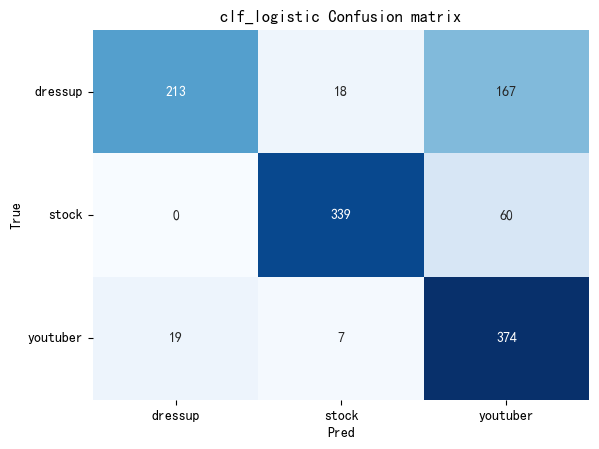

In [187]:
mapper = {"Stock":"stock", "時尚":"dressup", "youtuber":"youtuber"}
ct['boardID'] = ct['boardID'].map(mapper)

X = ct['words']
y = ct['boardID']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

    ## Plot confusion matrix
cm = confusion_matrix(y, y_pred, labels=classes)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title=f"{best_model_name}" + " Confusion matrix",
)
plt.yticks(rotation=0)


### 微妙發現
從上面的結果不難看出，在真實穿搭版的資料分類為youtuber版的情況相對較為頻繁，這邊合理猜測部分穿搭版上的資料或多或少跟youtuber有所相關，使得分類穿搭版時有所混淆。

In [188]:
ct['pred'] = y_pred
ct.loc[:,['words', 'boardID',"pred"]]

,words,boardID,pred
0,心得 2023 石油 年報 分享 投入 資金 100 萬左右 扣掉 長榮 虧損 投報 45%...,stock,stock
1,Re 請益 股息 ETF 變飆 股會 常態 小魯 高手 今年 不到 股息 ETF 還算 有點...,stock,stock
2,新聞 中國 PMI 萎縮 恐釀 失業 減薪 惡性 原文 標題 中國 PMI 萎縮 恐釀 失業...,stock,stock
3,Re 新聞 中國 PMI 萎縮 恐釀 失業 減薪 惡性 各行各業 大力 整改 中國 經濟 迎...,stock,youtuber
4,創作 浮動 桌面上 PTT 追蹤 工具 隨時 即時 推文 置頂 隱藏 桌面 角落 PTT 程...,stock,stock
...,...,...,...
1195,老師 提告 再議 駁回 最終 提要 還沒 看過 前面 兩篇 先去 https www dca...,youtuber,youtuber
1196,愛莉莎莎 現在 改走 玉女 路線 真的 一點 體會 炮轟 感覺 以上 po 文章 出自 影片...,youtuber,youtuber
1197,大胃 丁丁 好像 很久沒 發片 之前 大胃 風波 坦白說 挑戰 交朋友 檯面 丁丁 應該 目...,youtuber,youtuber
1198,MINI VLOG 一天 旅遊 日常 永安 海螺 淡水 老街 2023 第一支 VLOG 影...,youtuber,youtuber


In [189]:
false_pred = ct.query("boardID != pred").loc[:,['words', 'boardID',"pred"]]
false_pred

,words,boardID,pred
3,Re 新聞 中國 PMI 萎縮 恐釀 失業 減薪 惡性 各行各業 大力 整改 中國 經濟 迎...,stock,youtuber
5,新聞 日本 石川 7.6 強震 最大 震度 氣象廳 原文 標題 日本 石川 7.6 強震 最...,stock,youtuber
15,心得 股版 vs 房版 過去 兩年 累計 房價 漲幅 房網 房價 統計 202312 對比 ...,stock,youtuber
31,新聞 美國 新規 生效 多款 電動車 失去 稅收 抵免 資格 原文 標題 美國 電池 採購 ...,stock,youtuber
35,Re 心得 股版 vs 房版 房板 十幾年 房版 一種 股版 完全 特性 房版 真正 超有 ...,stock,youtuber
...,...,...,...
1082,推薦 youtuber 請問 一下 有沒有 平常 推薦 YouTuber 運動 吃播 感謝,youtuber,dressup
1097,艾莉莎莎 買房 系列 艾莉莎莎 裝潢 匠氣 評論 風格 剛剛 發了 以下 文章 底下 酸民 ...,youtuber,dressup
1101,覺得 艾莉莎莎 新家 風格 https imgur com l3Z9UhO jpg http...,youtuber,dressup
1156,勾惡 幫主 分享 台南 議會 黑金 賄選 內幕 真的 看吧 https www youtub...,youtuber,dressup


In [190]:



false_pred.loc[false_pred['boardID']=='youtuber', :].head(50)

,words,boardID,pred
808,YT premium 湊團 被刪 嗚嗚 加進來 五名 目前 兩位 https line me...,youtuber,stock
822,MyBagLand EP.7 第一顆 COACH 專櫃 包包 開箱 Bag Unboxing...,youtuber,dressup
832,2023 阿嘟 之夜 布萊克 薛薛 旺兔 順利 聯歡 派對 之後 臨時 讓給,youtuber,stock
845,艾莉莎莎 買房 系列 持續 更新 買房 系列 持續 更新 中因 點說 實在話 第一 大辣辣 ...,youtuber,dressup
847,艾莉莎莎 買房 系列 持續 更新 買房 系列 持續 更新 中因 點說 實在話 第一 大辣辣 ...,youtuber,dressup
864,這是 VW 篇文章 轉貼 文章 更新 最新 版本 觀看 完整 內容,youtuber,dressup
866,蔡阿嘎 歐陽 妮妮 同框 https imgur com ToJ0rQi jpg https...,youtuber,dressup
880,德州 公路 旅行 VLOG Austin San Antonio Road Trip Moz...,youtuber,stock
883,黃金 傑洛 戰鬥 分享 轉載 https youtu be S7kU5 QhLbs,youtuber,stock
893,WEEKLY VLOG in Dallas 萬聖節 派對 BLACKPINK 演唱會 Pan...,youtuber,dressup


In [191]:
false_pred.loc[531, :]

words      白頭髮 現在 白髮 東西 多種 染髮 泡泡 補色 .... 最近 看到 有用 調理 染髮 凝...
boardID                                              dressup
pred                                                youtuber
Name: 531, dtype: object

In [192]:
pprint(false_pred['words'][531])

('白頭髮 現在 白髮 東西 多種 染髮 泡泡 補色 .... 最近 看到 有用 調理 染髮 凝露 方便 回家 目前 染髮 很快 確實 顏色 慢慢 洗上去 '
 '一點點 溫和 那種 洗完 頭皮 刺刺 癢癢 感覺 觀察 看看 繼續 效果 用過 染髮 凝露 多不多 習慣 白頭髮')
